# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

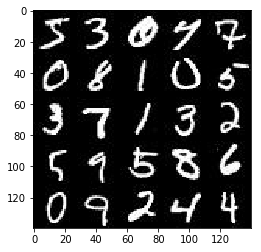

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

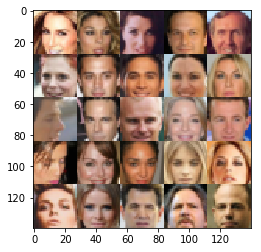

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    print('')
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name ='real_input')
    input_zim = tf.placeholder(tf.float32, [None, z_dim], name ='z_input')
    
    return input_real, input_zim, tf.placeholder(tf.float32, shape=(), name ='learn_rate')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False, alpha=0.2, drop_rate=0.0):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    print('discriminator')
    kinit = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=drop_rate)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.layers.dropout(x2, rate=drop_rate)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.layers.dropout(x3, rate=drop_rate)
        # 4x4x256
        
        x3 = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x3, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

discriminator
discriminator
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    print('generator')
    kinit = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 7x7x256
        print('x1:', x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=kinit,  padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        print('x2:', x2.shape)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=kinit,  padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        print('x3:', x3.shape)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
tf.ones_like([1,2,3]) * 2

<tf.Tensor 'mul:0' shape=(3,) dtype=int32>

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    print('model_loss')
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real) * (1-smooth))))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

model_loss
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)
discriminator
discriminator
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    print('model_opt')
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # TODO: Implement Function
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

model_opt
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print(
                        "Steps {}...".format(steps),
                        "Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


model_loss
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)
discriminator
discriminator
model_opt
Steps 10... Epoch 1/2... Discriminator Loss: 2.1299... Generator Loss: 0.3596
Steps 20... Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 1.1235
Steps 30... Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 2.1304
Steps 40... Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 2.8817
Steps 50... Epoch 1/2... Discriminator Loss: 0.4824... Generator Loss: 2.6419
Steps 60... Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.1842
Steps 70... Epoch 1/2... Discriminator Loss: 0.5501... Generator Loss: 2.1178
Steps 80... Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 1.9404
Steps 90... Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.8990
Steps 100... Epoch 1/2... Discriminator Loss: 6.6778... Generator Loss: 0.0119
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


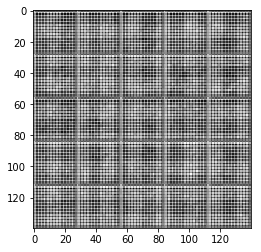

Steps 110... Epoch 1/2... Discriminator Loss: 2.5098... Generator Loss: 0.2168
Steps 120... Epoch 1/2... Discriminator Loss: 1.6353... Generator Loss: 0.7292
Steps 130... Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 0.6600
Steps 140... Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.6345
Steps 150... Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 1.6603
Steps 160... Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 1.4079
Steps 170... Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 3.2307
Steps 180... Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 4.4962
Steps 190... Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 5.3007
Steps 200... Epoch 1/2... Discriminator Loss: 2.2940... Generator Loss: 0.3517
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 210... Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.0121
Steps 220... Epoch 1/2... Discriminator Loss: 0.4777... Generator Loss: 2.2174
Steps 230... Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.5972
Steps 240... Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 3.2229
Steps 250... Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 3.1546
Steps 260... Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 1.0996
Steps 270... Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 3.6080
Steps 280... Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.8617
Steps 290... Epoch 1/2... Discriminator Loss: 0.6280... Generator Loss: 5.6204
Steps 300... Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 5.6023
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


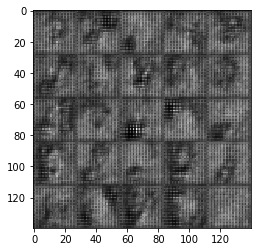

Steps 310... Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.1497
Steps 320... Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 5.0419
Steps 330... Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 2.2549
Steps 340... Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 3.2116
Steps 350... Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 1.2325
Steps 360... Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.5912
Steps 370... Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 4.4475
Steps 380... Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 6.7430
Steps 390... Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.6028
Steps 400... Epoch 1/2... Discriminator Loss: 1.1391... Generator Loss: 0.8109
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 410... Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 2.9319
Steps 420... Epoch 1/2... Discriminator Loss: 0.5934... Generator Loss: 1.8789
Steps 430... Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 1.1000
Steps 440... Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 2.4795
Steps 450... Epoch 1/2... Discriminator Loss: 2.7726... Generator Loss: 2.8428
Steps 460... Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.1486
Steps 470... Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 2.2859
Steps 480... Epoch 1/2... Discriminator Loss: 0.6587... Generator Loss: 1.3459
Steps 490... Epoch 1/2... Discriminator Loss: 0.4081... Generator Loss: 4.2139
Steps 500... Epoch 1/2... Discriminator Loss: 0.5389... Generator Loss: 1.8292
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


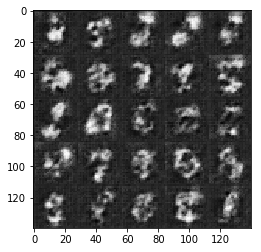

Steps 510... Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 3.0031
Steps 520... Epoch 1/2... Discriminator Loss: 0.4098... Generator Loss: 3.0516
Steps 530... Epoch 1/2... Discriminator Loss: 0.3510... Generator Loss: 4.7738
Steps 540... Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.6993
Steps 550... Epoch 1/2... Discriminator Loss: 0.6267... Generator Loss: 1.5861
Steps 560... Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 2.8759
Steps 570... Epoch 1/2... Discriminator Loss: 0.3804... Generator Loss: 4.1962
Steps 580... Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 2.0131
Steps 590... Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 5.3192
Steps 600... Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.2777
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


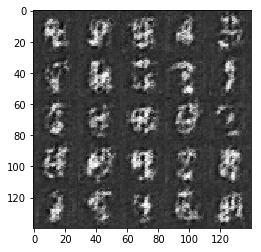

Steps 610... Epoch 1/2... Discriminator Loss: 0.4175... Generator Loss: 2.6293
Steps 620... Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 3.6222
Steps 630... Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 4.8000
Steps 640... Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 1.0666
Steps 650... Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.4104
Steps 660... Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 4.8764
Steps 670... Epoch 1/2... Discriminator Loss: 1.9906... Generator Loss: 3.3531
Steps 680... Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 1.4711
Steps 690... Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 1.3162
Steps 700... Epoch 1/2... Discriminator Loss: 0.3865... Generator Loss: 3.4243
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 710... Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 2.2244
Steps 720... Epoch 1/2... Discriminator Loss: 0.3978... Generator Loss: 2.9706
Steps 730... Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 5.2546
Steps 740... Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.2829
Steps 750... Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 2.0239
Steps 760... Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.1720
Steps 770... Epoch 1/2... Discriminator Loss: 0.4749... Generator Loss: 3.0323
Steps 780... Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.9738
Steps 790... Epoch 1/2... Discriminator Loss: 0.4778... Generator Loss: 2.3956
Steps 800... Epoch 1/2... Discriminator Loss: 0.3706... Generator Loss: 3.9980
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


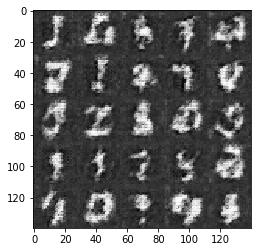

Steps 810... Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 5.2141
Steps 820... Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.9162
Steps 830... Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 4.3974
Steps 840... Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 2.7326
Steps 850... Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 1.7733
Steps 860... Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 2.6327
Steps 870... Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 5.7327
Steps 880... Epoch 1/2... Discriminator Loss: 0.9070... Generator Loss: 1.0360
Steps 890... Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 3.4288
Steps 900... Epoch 1/2... Discriminator Loss: 0.3602... Generator Loss: 5.4689
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 910... Epoch 1/2... Discriminator Loss: 0.4052... Generator Loss: 6.4313
Steps 920... Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 4.9852
Steps 930... Epoch 1/2... Discriminator Loss: 0.3746... Generator Loss: 3.4084
Steps 940... Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 7.3537
Steps 950... Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 4.7591
Steps 960... Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 2.3513
Steps 970... Epoch 1/2... Discriminator Loss: 1.6952... Generator Loss: 2.4290
Steps 980... Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.6896
Steps 990... Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 1.0416
Steps 1000... Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 1.9608
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


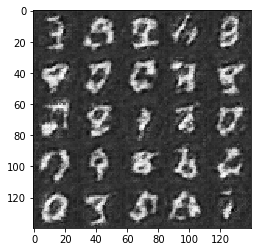

Steps 1010... Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 1.8508
Steps 1020... Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.7854
Steps 1030... Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 1.4490
Steps 1040... Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.9686
Steps 1050... Epoch 1/2... Discriminator Loss: 0.7264... Generator Loss: 2.2757
Steps 1060... Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 2.6715
Steps 1070... Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 1.6257
Steps 1080... Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 4.1435
Steps 1090... Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.0872
Steps 1100... Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 3.8211
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


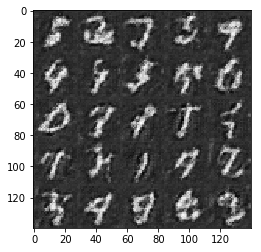

Steps 1110... Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.7358
Steps 1120... Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 3.8822
Steps 1130... Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 2.1472
Steps 1140... Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 3.7441
Steps 1150... Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.9426
Steps 1160... Epoch 1/2... Discriminator Loss: 0.3466... Generator Loss: 4.8270
Steps 1170... Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 1.3939
Steps 1180... Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 1.6192
Steps 1190... Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.0500
Steps 1200... Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 1.4204
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1210... Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 2.7543
Steps 1220... Epoch 1/2... Discriminator Loss: 0.4450... Generator Loss: 2.5513
Steps 1230... Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 1.2153
Steps 1240... Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 1.7633
Steps 1250... Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 2.6994
Steps 1260... Epoch 1/2... Discriminator Loss: 0.5505... Generator Loss: 1.9183
Steps 1270... Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 3.7677
Steps 1280... Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 4.3036
Steps 1290... Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 6.3772
Steps 1300... Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 2.4367
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1310... Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 6.3299
Steps 1320... Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.5148
Steps 1330... Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 3.6500
Steps 1340... Epoch 1/2... Discriminator Loss: 0.3905... Generator Loss: 3.1335
Steps 1350... Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 4.6919
Steps 1360... Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 2.5065
Steps 1370... Epoch 1/2... Discriminator Loss: 0.5109... Generator Loss: 2.7373
Steps 1380... Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 5.1998
Steps 1390... Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 2.5491
Steps 1400... Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 5.3500
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


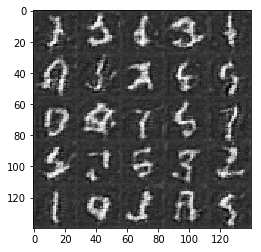

Steps 1410... Epoch 1/2... Discriminator Loss: 0.3529... Generator Loss: 4.1434
Steps 1420... Epoch 1/2... Discriminator Loss: 2.0300... Generator Loss: 0.2606
Steps 1430... Epoch 1/2... Discriminator Loss: 0.7106... Generator Loss: 1.6888
Steps 1440... Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.1018
Steps 1450... Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.1695
Steps 1460... Epoch 1/2... Discriminator Loss: 0.5346... Generator Loss: 2.5788
Steps 1470... Epoch 1/2... Discriminator Loss: 1.5385... Generator Loss: 0.5840
Steps 1480... Epoch 1/2... Discriminator Loss: 0.3696... Generator Loss: 4.1051
Steps 1490... Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.5850
Steps 1500... Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 1.6597
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


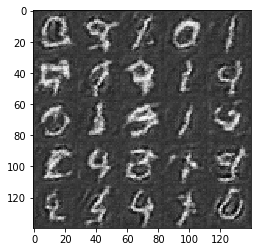

Steps 1510... Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 3.0983
Steps 1520... Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 6.2012
Steps 1530... Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 2.8915
Steps 1540... Epoch 1/2... Discriminator Loss: 0.3506... Generator Loss: 4.0707
Steps 1550... Epoch 1/2... Discriminator Loss: 0.3437... Generator Loss: 4.4526
Steps 1560... Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 4.4247
Steps 1570... Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 5.7856
Steps 1580... Epoch 1/2... Discriminator Loss: 0.3577... Generator Loss: 4.2288
Steps 1590... Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 0.9482
Steps 1600... Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.0877
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


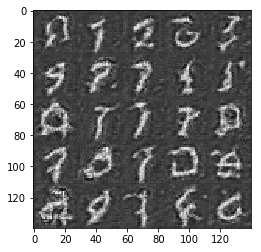

Steps 1610... Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 1.6174
Steps 1620... Epoch 1/2... Discriminator Loss: 0.4414... Generator Loss: 2.5346
Steps 1630... Epoch 1/2... Discriminator Loss: 0.3635... Generator Loss: 3.7754
Steps 1640... Epoch 1/2... Discriminator Loss: 0.4080... Generator Loss: 3.9975
Steps 1650... Epoch 1/2... Discriminator Loss: 0.3718... Generator Loss: 4.2523
Steps 1660... Epoch 1/2... Discriminator Loss: 0.3567... Generator Loss: 4.2884
Steps 1670... Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 5.2720
Steps 1680... Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.1455
Steps 1690... Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 5.0784
Steps 1700... Epoch 1/2... Discriminator Loss: 0.3668... Generator Loss: 4.1655
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1710... Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 3.6763
Steps 1720... Epoch 1/2... Discriminator Loss: 9.4807... Generator Loss: 0.0020
Steps 1730... Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 2.5917
Steps 1740... Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 1.4919
Steps 1750... Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 1.1472
Steps 1760... Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 1.1204
Steps 1770... Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.4892
Steps 1780... Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.6694
Steps 1790... Epoch 1/2... Discriminator Loss: 0.5200... Generator Loss: 2.3534
Steps 1800... Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 2.0589
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


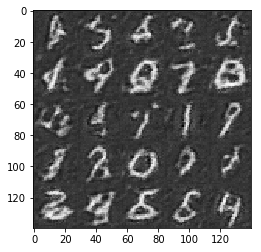

Steps 1810... Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 1.7629
Steps 1820... Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 1.9939
Steps 1830... Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 1.1223
Steps 1840... Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 3.8364
Steps 1850... Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.3187
Steps 1860... Epoch 1/2... Discriminator Loss: 0.4245... Generator Loss: 2.7224
Steps 1870... Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 4.3618
Steps 1880... Epoch 2/2... Discriminator Loss: 0.4131... Generator Loss: 2.9006
Steps 1890... Epoch 2/2... Discriminator Loss: 0.3413... Generator Loss: 5.8110
Steps 1900... Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.8952
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


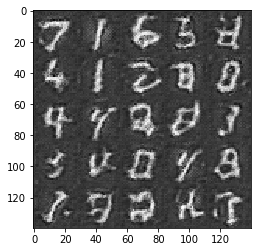

Steps 1910... Epoch 2/2... Discriminator Loss: 0.3892... Generator Loss: 3.4107
Steps 1920... Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 3.5484
Steps 1930... Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 2.7343
Steps 1940... Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 2.9391
Steps 1950... Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 1.4938
Steps 1960... Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 2.5823
Steps 1970... Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.0642
Steps 1980... Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 2.5442
Steps 1990... Epoch 2/2... Discriminator Loss: 0.3413... Generator Loss: 5.0633
Steps 2000... Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 2.6176
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


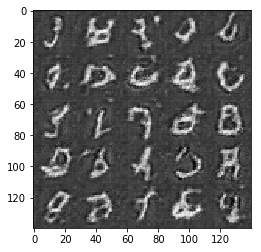

Steps 2010... Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.0265
Steps 2020... Epoch 2/2... Discriminator Loss: 0.4225... Generator Loss: 2.7284
Steps 2030... Epoch 2/2... Discriminator Loss: 0.3589... Generator Loss: 4.3086
Steps 2040... Epoch 2/2... Discriminator Loss: 0.3502... Generator Loss: 4.4462
Steps 2050... Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 3.3243
Steps 2060... Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 3.0139
Steps 2070... Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 2.9037
Steps 2080... Epoch 2/2... Discriminator Loss: 0.4306... Generator Loss: 2.6370
Steps 2090... Epoch 2/2... Discriminator Loss: 0.4456... Generator Loss: 2.5578
Steps 2100... Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 2.4207
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


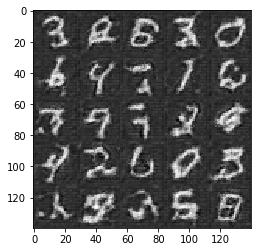

Steps 2110... Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 3.9181
Steps 2120... Epoch 2/2... Discriminator Loss: 0.3409... Generator Loss: 5.2342
Steps 2130... Epoch 2/2... Discriminator Loss: 0.3365... Generator Loss: 5.2081
Steps 2140... Epoch 2/2... Discriminator Loss: 0.4949... Generator Loss: 2.0346
Steps 2150... Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 4.7458
Steps 2160... Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 3.0435
Steps 2170... Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.8100
Steps 2180... Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 4.1802
Steps 2190... Epoch 2/2... Discriminator Loss: 0.3478... Generator Loss: 4.6590
Steps 2200... Epoch 2/2... Discriminator Loss: 0.4405... Generator Loss: 2.5300
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 2210... Epoch 2/2... Discriminator Loss: 0.3884... Generator Loss: 3.8492
Steps 2220... Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 6.0252
Steps 2230... Epoch 2/2... Discriminator Loss: 0.3896... Generator Loss: 3.3957
Steps 2240... Epoch 2/2... Discriminator Loss: 0.4025... Generator Loss: 2.9479
Steps 2250... Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 1.9905
Steps 2260... Epoch 2/2... Discriminator Loss: 0.3423... Generator Loss: 6.8552
Steps 2270... Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 4.1662
Steps 2280... Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.5328
Steps 2290... Epoch 2/2... Discriminator Loss: 0.5396... Generator Loss: 2.9210
Steps 2300... Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.9965
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 2310... Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 4.2336
Steps 2320... Epoch 2/2... Discriminator Loss: 0.5475... Generator Loss: 1.9054
Steps 2330... Epoch 2/2... Discriminator Loss: 1.5215... Generator Loss: 0.6212
Steps 2340... Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.3466
Steps 2350... Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 2.4200
Steps 2360... Epoch 2/2... Discriminator Loss: 0.3684... Generator Loss: 5.1436
Steps 2370... Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 2.9597
Steps 2380... Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 1.6518
Steps 2390... Epoch 2/2... Discriminator Loss: 0.3665... Generator Loss: 4.6740
Steps 2400... Epoch 2/2... Discriminator Loss: 0.4569... Generator Loss: 2.6845
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 2410... Epoch 2/2... Discriminator Loss: 0.3747... Generator Loss: 4.6361
Steps 2420... Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 4.5484
Steps 2430... Epoch 2/2... Discriminator Loss: 0.4092... Generator Loss: 2.9998
Steps 2440... Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 1.7931
Steps 2450... Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 3.2139
Steps 2460... Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.6392
Steps 2470... Epoch 2/2... Discriminator Loss: 0.3486... Generator Loss: 5.9234
Steps 2480... Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.3473
Steps 2490... Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 5.3616
Steps 2500... Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 1.8280
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 2510... Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 5.6637
Steps 2520... Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 5.4122
Steps 2530... Epoch 2/2... Discriminator Loss: 0.3564... Generator Loss: 6.2763
Steps 2540... Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.7892
Steps 2550... Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 1.3597
Steps 2560... Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.3843
Steps 2570... Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.6606
Steps 2580... Epoch 2/2... Discriminator Loss: 1.0630... Generator Loss: 3.7171
Steps 2590... Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.6156
Steps 2600... Epoch 2/2... Discriminator Loss: 0.4620... Generator Loss: 2.3464
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 2610... Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.7839
Steps 2620... Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 5.9039
Steps 2630... Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 4.1165
Steps 2640... Epoch 2/2... Discriminator Loss: 0.3712... Generator Loss: 4.1287
Steps 2650... Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 2.0399
Steps 2660... Epoch 2/2... Discriminator Loss: 0.4961... Generator Loss: 2.0858
Steps 2670... Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 3.3645
Steps 2680... Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.6180
Steps 2690... Epoch 2/2... Discriminator Loss: 0.3668... Generator Loss: 4.6922
Steps 2700... Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.8290
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 2710... Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 3.0532
Steps 2720... Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 4.1585
Steps 2730... Epoch 2/2... Discriminator Loss: 0.4411... Generator Loss: 4.4013
Steps 2740... Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 4.2184
Steps 2750... Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 0.9167
Steps 2760... Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 2.3562
Steps 2770... Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.9026
Steps 2780... Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 3.8449
Steps 2790... Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.5096
Steps 2800... Epoch 2/2... Discriminator Loss: 0.3937... Generator Loss: 3.2259
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


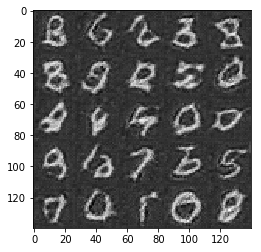

Steps 2810... Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.7549
Steps 2820... Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 4.0228
Steps 2830... Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 5.2767
Steps 2840... Epoch 2/2... Discriminator Loss: 0.3906... Generator Loss: 3.2116
Steps 2850... Epoch 2/2... Discriminator Loss: 0.3465... Generator Loss: 4.5811
Steps 2860... Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 2.5339
Steps 2870... Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.4085
Steps 2880... Epoch 2/2... Discriminator Loss: 0.4678... Generator Loss: 2.1841
Steps 2890... Epoch 2/2... Discriminator Loss: 0.3798... Generator Loss: 3.4813
Steps 2900... Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 6.9805
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


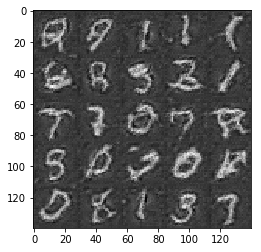

Steps 2910... Epoch 2/2... Discriminator Loss: 0.3623... Generator Loss: 4.2291
Steps 2920... Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 5.0597
Steps 2930... Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 4.0639
Steps 2940... Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 4.2671
Steps 2950... Epoch 2/2... Discriminator Loss: 0.3403... Generator Loss: 6.2547
Steps 2960... Epoch 2/2... Discriminator Loss: 0.4156... Generator Loss: 2.7932
Steps 2970... Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 5.0681
Steps 2980... Epoch 2/2... Discriminator Loss: 0.3386... Generator Loss: 5.9685
Steps 2990... Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 5.3545
Steps 3000... Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 5.8853
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


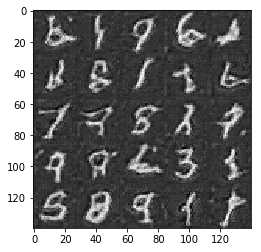

Steps 3010... Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 2.0663
Steps 3020... Epoch 2/2... Discriminator Loss: 2.0339... Generator Loss: 5.6173
Steps 3030... Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 3.4265
Steps 3040... Epoch 2/2... Discriminator Loss: 0.3710... Generator Loss: 5.5771
Steps 3050... Epoch 2/2... Discriminator Loss: 0.3906... Generator Loss: 3.0758
Steps 3060... Epoch 2/2... Discriminator Loss: 0.4384... Generator Loss: 2.4979
Steps 3070... Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 6.1439
Steps 3080... Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 6.3316
Steps 3090... Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 3.5802
Steps 3100... Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 3.6646
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


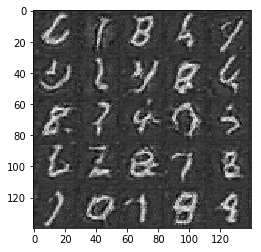

Steps 3110... Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 3.4157
Steps 3120... Epoch 2/2... Discriminator Loss: 0.4980... Generator Loss: 7.1472
Steps 3130... Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 5.2869
Steps 3140... Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 3.5402
Steps 3150... Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 3.2104
Steps 3160... Epoch 2/2... Discriminator Loss: 0.4095... Generator Loss: 3.0611
Steps 3170... Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.3637
Steps 3180... Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 4.1422
Steps 3190... Epoch 2/2... Discriminator Loss: 0.3464... Generator Loss: 4.5966
Steps 3200... Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 3.8070
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


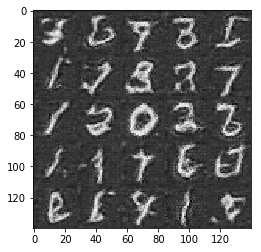

Steps 3210... Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.7300
Steps 3220... Epoch 2/2... Discriminator Loss: 0.4439... Generator Loss: 2.4834
Steps 3230... Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 5.0746
Steps 3240... Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 3.0809
Steps 3250... Epoch 2/2... Discriminator Loss: 0.3330... Generator Loss: 7.2030
Steps 3260... Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 5.3025
Steps 3270... Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 2.4908
Steps 3280... Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 3.2827
Steps 3290... Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 1.9259
Steps 3300... Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 2.5956
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


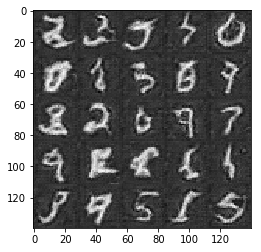

Steps 3310... Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.9723
Steps 3320... Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 5.1164
Steps 3330... Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 4.4293
Steps 3340... Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 4.1518
Steps 3350... Epoch 2/2... Discriminator Loss: 0.3654... Generator Loss: 3.9654
Steps 3360... Epoch 2/2... Discriminator Loss: 0.3407... Generator Loss: 6.2501
Steps 3370... Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 2.5223
Steps 3380... Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 3.9971
Steps 3390... Epoch 2/2... Discriminator Loss: 0.4087... Generator Loss: 2.7565
Steps 3400... Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 5.8182
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


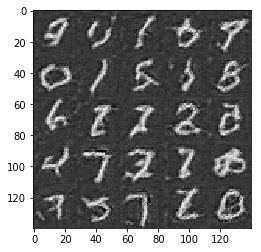

Steps 3410... Epoch 2/2... Discriminator Loss: 0.3677... Generator Loss: 3.7255
Steps 3420... Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.6946
Steps 3430... Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 1.6380
Steps 3440... Epoch 2/2... Discriminator Loss: 0.4587... Generator Loss: 2.4024
Steps 3450... Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 2.2493
Steps 3460... Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 3.8427
Steps 3470... Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 3.3939
Steps 3480... Epoch 2/2... Discriminator Loss: 0.4771... Generator Loss: 2.4697
Steps 3490... Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 2.3193
Steps 3500... Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 4.8603
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


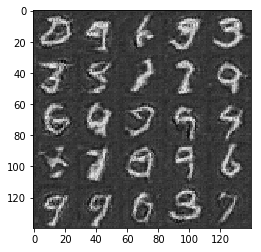

Steps 3510... Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.9696
Steps 3520... Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 3.1817
Steps 3530... Epoch 2/2... Discriminator Loss: 0.8573... Generator Loss: 1.1165
Steps 3540... Epoch 2/2... Discriminator Loss: 0.3702... Generator Loss: 4.0811
Steps 3550... Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 4.9947
Steps 3560... Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.7755
Steps 3570... Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.3464
Steps 3580... Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.5318
Steps 3590... Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 1.0797
Steps 3600... Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 1.3507
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


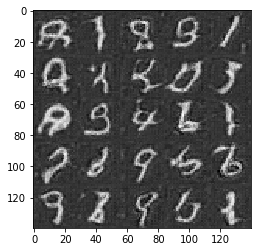

Steps 3610... Epoch 2/2... Discriminator Loss: 0.3507... Generator Loss: 5.2718
Steps 3620... Epoch 2/2... Discriminator Loss: 0.4194... Generator Loss: 3.7807
Steps 3630... Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 3.0866
Steps 3640... Epoch 2/2... Discriminator Loss: 0.6197... Generator Loss: 2.0675
Steps 3650... Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 3.3287
Steps 3660... Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 1.5828
Steps 3670... Epoch 2/2... Discriminator Loss: 0.3734... Generator Loss: 3.7518
Steps 3680... Epoch 2/2... Discriminator Loss: 0.3757... Generator Loss: 3.3536
Steps 3690... Epoch 2/2... Discriminator Loss: 0.3575... Generator Loss: 4.0217
Steps 3700... Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 3.2400
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 3710... Epoch 2/2... Discriminator Loss: 0.3671... Generator Loss: 4.3448
Steps 3720... Epoch 2/2... Discriminator Loss: 0.3621... Generator Loss: 3.6943
Steps 3730... Epoch 2/2... Discriminator Loss: 0.5537... Generator Loss: 1.9206
Steps 3740... Epoch 2/2... Discriminator Loss: 0.3474... Generator Loss: 4.9868
Steps 3750... Epoch 2/2... Discriminator Loss: 0.3367... Generator Loss: 9.4426


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.


model_loss
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)
discriminator
discriminator
model_opt
Steps 10... Epoch 1/1... Discriminator Loss: 2.9724... Generator Loss: 0.1299
Steps 20... Epoch 1/1... Discriminator Loss: 2.2544... Generator Loss: 0.3895
Steps 30... Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6470
Steps 40... Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7103
Steps 50... Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.2225
Steps 60... Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 2.6618
Steps 70... Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 3.0160
Steps 80... Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 6.0438
Steps 90... Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 2.7878
Steps 100... Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.5200
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 110... Epoch 1/1... Discriminator Loss: 2.1278... Generator Loss: 0.3100
Steps 120... Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.6121
Steps 130... Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 3.6585
Steps 140... Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 4.5475
Steps 150... Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 2.4955
Steps 160... Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 3.0611
Steps 170... Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.4328
Steps 180... Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 3.1569
Steps 190... Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.6563
Steps 200... Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 2.4424
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


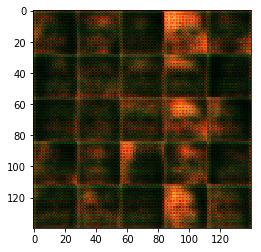

Steps 210... Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 3.9270
Steps 220... Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 1.9690
Steps 230... Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.4427
Steps 240... Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.4766
Steps 250... Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.3064
Steps 260... Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 3.4051
Steps 270... Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 2.1423
Steps 280... Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 2.3505
Steps 290... Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.6009
Steps 300... Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 3.5622
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


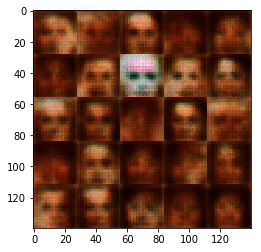

Steps 310... Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 4.5420
Steps 320... Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 2.1803
Steps 330... Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 2.3589
Steps 340... Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.2857
Steps 350... Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 1.8439
Steps 360... Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 3.5312
Steps 370... Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.3347
Steps 380... Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.9498
Steps 390... Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.6435
Steps 400... Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 3.3197
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


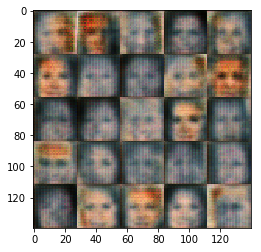

Steps 410... Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 2.0501
Steps 420... Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.2276
Steps 430... Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.9717
Steps 440... Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.9620
Steps 450... Epoch 1/1... Discriminator Loss: 1.7679... Generator Loss: 5.5611
Steps 460... Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.8063
Steps 470... Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7370
Steps 480... Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.5876
Steps 490... Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.0628
Steps 500... Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 2.9779
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


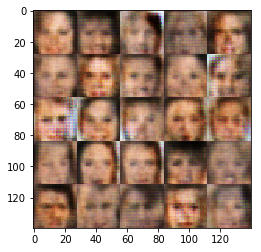

Steps 510... Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.9584
Steps 520... Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 2.9919
Steps 530... Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.8216
Steps 540... Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 3.8173
Steps 550... Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.4223
Steps 560... Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 3.6097
Steps 570... Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.4676
Steps 580... Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 4.3673
Steps 590... Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.9726
Steps 600... Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.4888
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 610... Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 5.5532
Steps 620... Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.5611
Steps 630... Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.7112
Steps 640... Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.3823
Steps 650... Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.8682
Steps 660... Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 5.8168
Steps 670... Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6143
Steps 680... Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9317
Steps 690... Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.9155
Steps 700... Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 3.9605
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 710... Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7690
Steps 720... Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 3.0551
Steps 730... Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 3.5595
Steps 740... Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 2.3491
Steps 750... Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.4322
Steps 760... Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.5715
Steps 770... Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5928
Steps 780... Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9235
Steps 790... Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.0324
Steps 800... Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.3189
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 810... Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 0.3959
Steps 820... Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.0404
Steps 830... Epoch 1/1... Discriminator Loss: 1.7920... Generator Loss: 0.4323
Steps 840... Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 2.0310
Steps 850... Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.9506
Steps 860... Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.4815
Steps 870... Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 4.8125
Steps 880... Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.3903
Steps 890... Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6167
Steps 900... Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9549
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


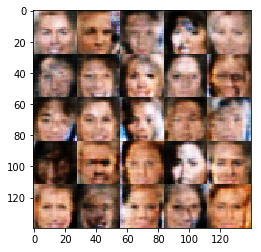

Steps 910... Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 2.7574
Steps 920... Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.4942
Steps 930... Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.7853
Steps 940... Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7262
Steps 950... Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7737
Steps 960... Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 3.1375
Steps 970... Epoch 1/1... Discriminator Loss: 2.2547... Generator Loss: 0.2470
Steps 980... Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 2.3961
Steps 990... Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.9537
Steps 1000... Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 3.6472
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


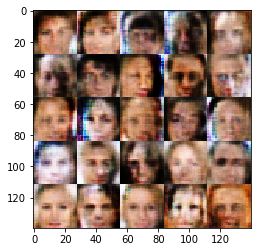

Steps 1010... Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.2478
Steps 1020... Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 5.1100
Steps 1030... Epoch 1/1... Discriminator Loss: 1.8837... Generator Loss: 0.3384
Steps 1040... Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8058
Steps 1050... Epoch 1/1... Discriminator Loss: 2.1578... Generator Loss: 2.5164
Steps 1060... Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 3.4451
Steps 1070... Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 3.4931
Steps 1080... Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9826
Steps 1090... Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8767
Steps 1100... Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9596
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


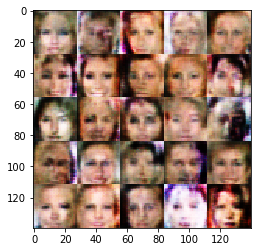

Steps 1110... Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 2.2976
Steps 1120... Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.6308
Steps 1130... Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 2.6812
Steps 1140... Epoch 1/1... Discriminator Loss: 1.7512... Generator Loss: 1.6622
Steps 1150... Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9750
Steps 1160... Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.2369
Steps 1170... Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 4.0487
Steps 1180... Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 4.0910
Steps 1190... Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.1036
Steps 1200... Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 2.6812
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1210... Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 2.6602
Steps 1220... Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 1.7462
Steps 1230... Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.7058
Steps 1240... Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 1.3022
Steps 1250... Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.0671
Steps 1260... Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.2421
Steps 1270... Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9167
Steps 1280... Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0295
Steps 1290... Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.0994
Steps 1300... Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.9837
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


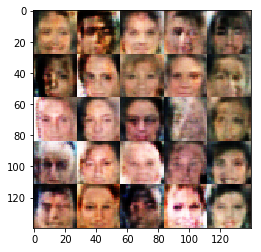

Steps 1310... Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.0811
Steps 1320... Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.1030
Steps 1330... Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.2634
Steps 1340... Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 4.2209
Steps 1350... Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.5104
Steps 1360... Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 1.9604
Steps 1370... Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7812
Steps 1380... Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.1556
Steps 1390... Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.3787
Steps 1400... Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.1970
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


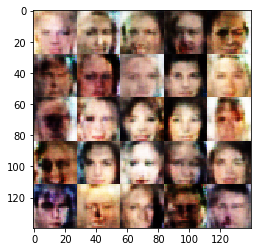

Steps 1410... Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 1.6788
Steps 1420... Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5412
Steps 1430... Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.2871
Steps 1440... Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 3.4822
Steps 1450... Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.4349
Steps 1460... Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8269
Steps 1470... Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.0823
Steps 1480... Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9473
Steps 1490... Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 2.0563
Steps 1500... Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 4.8108
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1510... Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.4697
Steps 1520... Epoch 1/1... Discriminator Loss: 1.8878... Generator Loss: 0.6139
Steps 1530... Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.8303
Steps 1540... Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.3204
Steps 1550... Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9413
Steps 1560... Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.0023
Steps 1570... Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.9504
Steps 1580... Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.9879
Steps 1590... Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8266
Steps 1600... Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7733
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1610... Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.9625
Steps 1620... Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.0009
Steps 1630... Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 1.5604
Steps 1640... Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 2.4268
Steps 1650... Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 1.4766
Steps 1660... Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8171
Steps 1670... Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.9948
Steps 1680... Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.9520
Steps 1690... Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8693
Steps 1700... Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.1200
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 1710... Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.1666
Steps 1720... Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.0077
Steps 1730... Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.3407
Steps 1740... Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.0592
Steps 1750... Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.2950
Steps 1760... Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9594
Steps 1770... Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8504
Steps 1780... Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7075
Steps 1790... Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.6887
Steps 1800... Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.2009
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


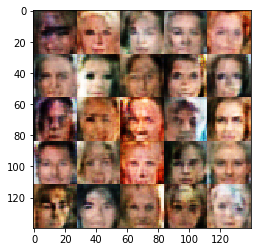

Steps 1810... Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 3.2469
Steps 1820... Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 1.2255
Steps 1830... Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 4.0810
Steps 1840... Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.8829
Steps 1850... Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.1931
Steps 1860... Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.9697
Steps 1870... Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1592
Steps 1880... Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.2166
Steps 1890... Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7005
Steps 1900... Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.2134
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


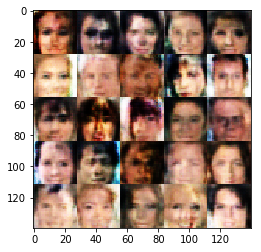

Steps 1910... Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.4918
Steps 1920... Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.9006
Steps 1930... Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.9055
Steps 1940... Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.7745
Steps 1950... Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.3431
Steps 1960... Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7708
Steps 1970... Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.1168
Steps 1980... Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.3032
Steps 1990... Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 3.5100
Steps 2000... Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.0444
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


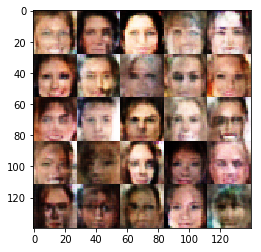

Steps 2010... Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.0062
Steps 2020... Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.2141
Steps 2030... Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.4256
Steps 2040... Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.9285
Steps 2050... Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.7389
Steps 2060... Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 2.9622
Steps 2070... Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 3.7298
Steps 2080... Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 4.3287
Steps 2090... Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6129
Steps 2100... Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8603
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


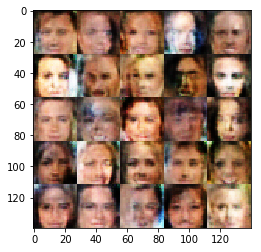

Steps 2110... Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.3377
Steps 2120... Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.1504
Steps 2130... Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.1144
Steps 2140... Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8602
Steps 2150... Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.9375
Steps 2160... Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5749
Steps 2170... Epoch 1/1... Discriminator Loss: 2.8703... Generator Loss: 4.0302
Steps 2180... Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 2.3167
Steps 2190... Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.8469
Steps 2200... Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.4147
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


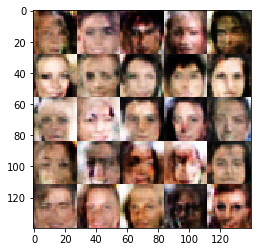

Steps 2210... Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 3.3024
Steps 2220... Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.0505
Steps 2230... Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 3.2860
Steps 2240... Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 3.9783
Steps 2250... Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.4488
Steps 2260... Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.0224
Steps 2270... Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 2.5436
Steps 2280... Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.2444
Steps 2290... Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.2284
Steps 2300... Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7644
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


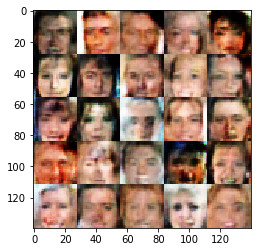

Steps 2310... Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.4948
Steps 2320... Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.8600
Steps 2330... Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 3.1201
Steps 2340... Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.3128
Steps 2350... Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.3895
Steps 2360... Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1306
Steps 2370... Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6413
Steps 2380... Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7340
Steps 2390... Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.8611
Steps 2400... Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 2.7382
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


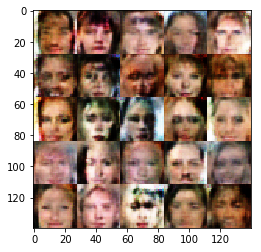

Steps 2410... Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 1.6587
Steps 2420... Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 4.0013
Steps 2430... Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 2.2719
Steps 2440... Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7826
Steps 2450... Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 3.4507
Steps 2460... Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 4.7210
Steps 2470... Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 4.2908
Steps 2480... Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.2637
Steps 2490... Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.1300
Steps 2500... Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6781
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


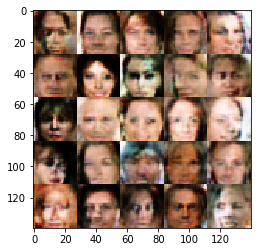

Steps 2510... Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.3163
Steps 2520... Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.1794
Steps 2530... Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 3.1937
Steps 2540... Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.6706
Steps 2550... Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 4.7248
Steps 2560... Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.6989
Steps 2570... Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.0966
Steps 2580... Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.0057
Steps 2590... Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.1569
Steps 2600... Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.5797
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


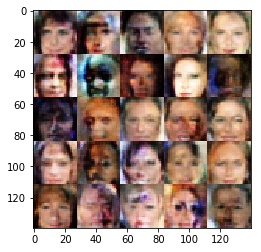

Steps 2610... Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.6805
Steps 2620... Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.0246
Steps 2630... Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.0620
Steps 2640... Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.7284
Steps 2650... Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.1601
Steps 2660... Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 2.6919
Steps 2670... Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.8396
Steps 2680... Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 4.8359
Steps 2690... Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.5657
Steps 2700... Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 0.9835
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


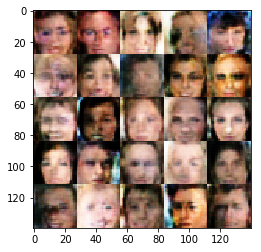

Steps 2710... Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 2.0454
Steps 2720... Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.8153
Steps 2730... Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 2.0740
Steps 2740... Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.9333
Steps 2750... Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9421
Steps 2760... Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.4469
Steps 2770... Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 1.6254
Steps 2780... Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 4.1971
Steps 2790... Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.3537
Steps 2800... Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 3.1348
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


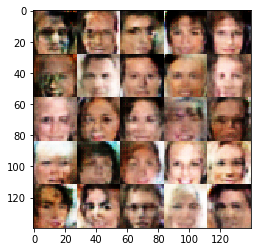

Steps 2810... Epoch 1/1... Discriminator Loss: 1.9889... Generator Loss: 4.0083
Steps 2820... Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.8644
Steps 2830... Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 2.7260
Steps 2840... Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.6919
Steps 2850... Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.2203
Steps 2860... Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.1849
Steps 2870... Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 3.0396
Steps 2880... Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.0010
Steps 2890... Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 1.8635
Steps 2900... Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 1.3543
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


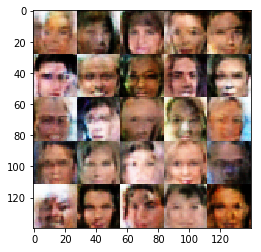

Steps 2910... Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.4984
Steps 2920... Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.7440
Steps 2930... Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 4.7364
Steps 2940... Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.5925
Steps 2950... Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.4628
Steps 2960... Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.2249
Steps 2970... Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.1766
Steps 2980... Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.4628
Steps 2990... Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 2.2211
Steps 3000... Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 1.9889
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


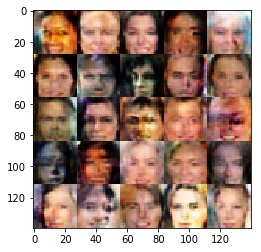

Steps 3010... Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.4655
Steps 3020... Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 3.4453
Steps 3030... Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.2513
Steps 3040... Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 2.6924
Steps 3050... Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.4551
Steps 3060... Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.4128
Steps 3070... Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 2.0101
Steps 3080... Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.2105
Steps 3090... Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.0955
Steps 3100... Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 3.3096
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


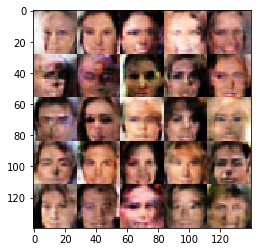

Steps 3110... Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.3101
Steps 3120... Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.8155
Steps 3130... Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8828
Steps 3140... Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.3314
Steps 3150... Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 2.3671
Steps 3160... Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.5861
Steps 3170... Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.3473
Steps 3180... Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.1692
Steps 3190... Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 2.0345
Steps 3200... Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.8850
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


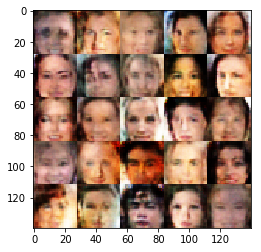

Steps 3210... Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.4873
Steps 3220... Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.9618
Steps 3230... Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.9092
Steps 3240... Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.0621
Steps 3250... Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.0661
Steps 3260... Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.3663
Steps 3270... Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.5614
Steps 3280... Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.3519
Steps 3290... Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.4244
Steps 3300... Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.0085
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 3310... Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 3.2035
Steps 3320... Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 2.4670
Steps 3330... Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.4873
Steps 3340... Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.4414
Steps 3350... Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.7158
Steps 3360... Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.5353
Steps 3370... Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 2.4806
Steps 3380... Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.1130
Steps 3390... Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.9206
Steps 3400... Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 3.0552
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 3410... Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.8696
Steps 3420... Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.5499
Steps 3430... Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 3.6511
Steps 3440... Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.4920
Steps 3450... Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.2344
Steps 3460... Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 2.4077
Steps 3470... Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 2.7293
Steps 3480... Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.7983
Steps 3490... Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9182
Steps 3500... Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.0089
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 3510... Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 3.1287
Steps 3520... Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8791
Steps 3530... Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 2.1584
Steps 3540... Epoch 1/1... Discriminator Loss: 2.1442... Generator Loss: 0.2385
Steps 3550... Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 1.9910
Steps 3560... Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.9407
Steps 3570... Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.7719
Steps 3580... Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5824
Steps 3590... Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.2045
Steps 3600... Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.2657
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


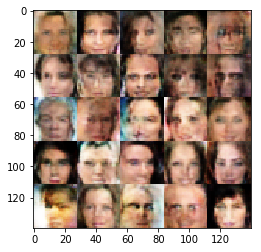

Steps 3610... Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.5445
Steps 3620... Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.6342
Steps 3630... Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.5100
Steps 3640... Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.2926
Steps 3650... Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.4592
Steps 3660... Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.8186
Steps 3670... Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.4913
Steps 3680... Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.6201
Steps 3690... Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.8235
Steps 3700... Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.6204
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


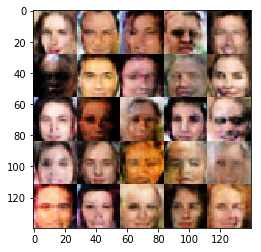

Steps 3710... Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.1514
Steps 3720... Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.9430
Steps 3730... Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.7882
Steps 3740... Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 2.3286
Steps 3750... Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 1.9905
Steps 3760... Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.2612
Steps 3770... Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.9660
Steps 3780... Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 2.0971
Steps 3790... Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.9439
Steps 3800... Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0110
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 3810... Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.8042
Steps 3820... Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.2347
Steps 3830... Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 1.4836
Steps 3840... Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.4621
Steps 3850... Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.0529
Steps 3860... Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 3.4329
Steps 3870... Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 2.2230
Steps 3880... Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6044
Steps 3890... Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 3.0688
Steps 3900... Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.6213
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 3910... Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.8563
Steps 3920... Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.9407
Steps 3930... Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.0151
Steps 3940... Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.7462
Steps 3950... Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.6333
Steps 3960... Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.2314
Steps 3970... Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.7019
Steps 3980... Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 2.4420
Steps 3990... Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.3114
Steps 4000... Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 3.2799
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 4010... Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.3818
Steps 4020... Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.4957
Steps 4030... Epoch 1/1... Discriminator Loss: 3.1186... Generator Loss: 0.1037
Steps 4040... Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.1420
Steps 4050... Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.5958
Steps 4060... Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.7835
Steps 4070... Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.0727
Steps 4080... Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5162
Steps 4090... Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.6156
Steps 4100... Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 0.9497
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 4110... Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.6151
Steps 4120... Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 1.5564
Steps 4130... Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.4725
Steps 4140... Epoch 1/1... Discriminator Loss: 1.9395... Generator Loss: 3.2075
Steps 4150... Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.1047
Steps 4160... Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.4383
Steps 4170... Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.4288
Steps 4180... Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.6595
Steps 4190... Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.1033
Steps 4200... Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.3177
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


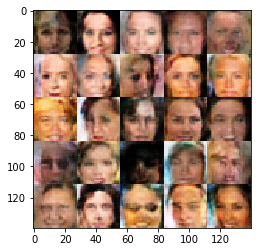

Steps 4210... Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.5519
Steps 4220... Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.6994
Steps 4230... Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 4.2003
Steps 4240... Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.2524
Steps 4250... Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.2262
Steps 4260... Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.5180
Steps 4270... Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.2623
Steps 4280... Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 3.2864
Steps 4290... Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.1368
Steps 4300... Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.0265
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


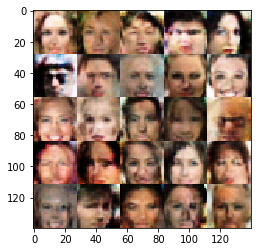

Steps 4310... Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.0005
Steps 4320... Epoch 1/1... Discriminator Loss: 1.9310... Generator Loss: 0.2640
Steps 4330... Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.3381
Steps 4340... Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.1836
Steps 4350... Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0149
Steps 4360... Epoch 1/1... Discriminator Loss: 1.7542... Generator Loss: 0.3723
Steps 4370... Epoch 1/1... Discriminator Loss: 2.3915... Generator Loss: 0.1816
Steps 4380... Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.4871
Steps 4390... Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 1.6906
Steps 4400... Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9064
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


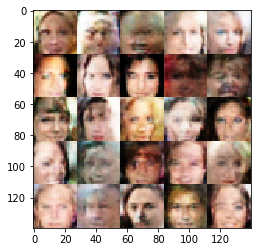

Steps 4410... Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.1102
Steps 4420... Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 3.8370
Steps 4430... Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 2.1078
Steps 4440... Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.1809
Steps 4450... Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.5900
Steps 4460... Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9588
Steps 4470... Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 2.9967
Steps 4480... Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.9262
Steps 4490... Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.7594
Steps 4500... Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 0.9645
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


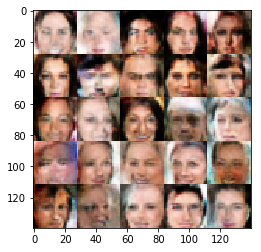

Steps 4510... Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.1247
Steps 4520... Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.3065
Steps 4530... Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 4.3873
Steps 4540... Epoch 1/1... Discriminator Loss: 1.9258... Generator Loss: 2.5877
Steps 4550... Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.2130
Steps 4560... Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8174
Steps 4570... Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 0.9394
Steps 4580... Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 2.1506
Steps 4590... Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.5476
Steps 4600... Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.5731
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


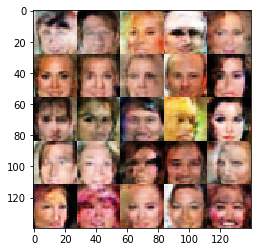

Steps 4610... Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.2245
Steps 4620... Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.6339
Steps 4630... Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 2.0235
Steps 4640... Epoch 1/1... Discriminator Loss: 1.8100... Generator Loss: 3.0183
Steps 4650... Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.6493
Steps 4660... Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.7085
Steps 4670... Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.0976
Steps 4680... Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.8229
Steps 4690... Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.4871
Steps 4700... Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.3450
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 4710... Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.0220
Steps 4720... Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.8593
Steps 4730... Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.0132
Steps 4740... Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.3320
Steps 4750... Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.6217
Steps 4760... Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.6068
Steps 4770... Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1431
Steps 4780... Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.3779
Steps 4790... Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6743
Steps 4800... Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 3.5079
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 4810... Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 2.5044
Steps 4820... Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.1055
Steps 4830... Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 2.3769
Steps 4840... Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 2.2120
Steps 4850... Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 3.1137
Steps 4860... Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.6938
Steps 4870... Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 2.2370
Steps 4880... Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.9380
Steps 4890... Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.4331
Steps 4900... Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.5329
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


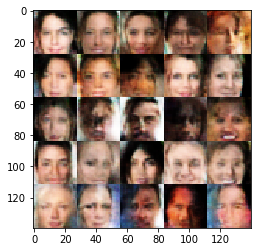

Steps 4910... Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5339
Steps 4920... Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.5819
Steps 4930... Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 4.3419
Steps 4940... Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 2.2091
Steps 4950... Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.8814
Steps 4960... Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 3.1523
Steps 4970... Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 2.0743
Steps 4980... Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 2.6366
Steps 4990... Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8546
Steps 5000... Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.0610
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


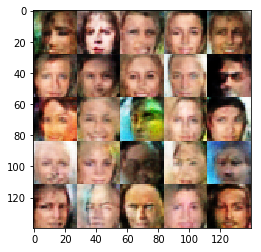

Steps 5010... Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.8164
Steps 5020... Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8629
Steps 5030... Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.0968
Steps 5040... Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 4.2231
Steps 5050... Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 0.9863
Steps 5060... Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.1965
Steps 5070... Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.0287
Steps 5080... Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.5342
Steps 5090... Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.5474
Steps 5100... Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.8706
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


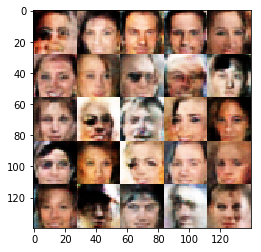

Steps 5110... Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.3803
Steps 5120... Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 2.5825
Steps 5130... Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 2.2557
Steps 5140... Epoch 1/1... Discriminator Loss: 1.7361... Generator Loss: 0.3743
Steps 5150... Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 2.1966
Steps 5160... Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.7059
Steps 5170... Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.4411
Steps 5180... Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 3.0937
Steps 5190... Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.1663
Steps 5200... Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0738
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 5210... Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.1853
Steps 5220... Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 2.1878
Steps 5230... Epoch 1/1... Discriminator Loss: 1.8696... Generator Loss: 0.3246
Steps 5240... Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.3960
Steps 5250... Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.5715
Steps 5260... Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 5.6891
Steps 5270... Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.0124
Steps 5280... Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.8326
Steps 5290... Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.1567
Steps 5300... Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 2.3081
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


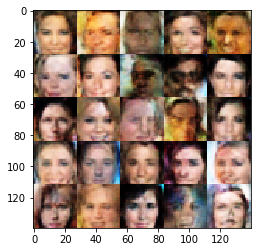

Steps 5310... Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.9769
Steps 5320... Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.4254
Steps 5330... Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.1864
Steps 5340... Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 3.0478
Steps 5350... Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.2713
Steps 5360... Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.2243
Steps 5370... Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 2.7096
Steps 5380... Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.5153
Steps 5390... Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.2862
Steps 5400... Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.3863
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 5410... Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.8323
Steps 5420... Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.7718
Steps 5430... Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.1175
Steps 5440... Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.8485
Steps 5450... Epoch 1/1... Discriminator Loss: 1.9920... Generator Loss: 1.6328
Steps 5460... Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.3190
Steps 5470... Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.9872
Steps 5480... Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.6558
Steps 5490... Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 3.5342
Steps 5500... Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 0.3607
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


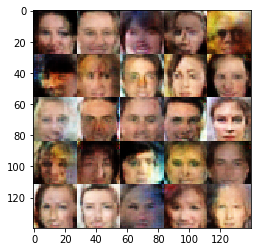

Steps 5510... Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.6380
Steps 5520... Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.3483
Steps 5530... Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8634
Steps 5540... Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.5679
Steps 5550... Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.4594
Steps 5560... Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.3395
Steps 5570... Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 0.9500
Steps 5580... Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4339
Steps 5590... Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.2220
Steps 5600... Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.8207
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


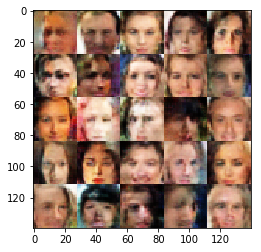

Steps 5610... Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.7100
Steps 5620... Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 4.2716
Steps 5630... Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.5561
Steps 5640... Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.8272
Steps 5650... Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.5416
Steps 5660... Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.5108
Steps 5670... Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 2.8511
Steps 5680... Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.4388
Steps 5690... Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.2324
Steps 5700... Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.8073
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 5710... Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.2121
Steps 5720... Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.4092
Steps 5730... Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.6087
Steps 5740... Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5416
Steps 5750... Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.1514
Steps 5760... Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.7433
Steps 5770... Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.9414
Steps 5780... Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6403
Steps 5790... Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7200
Steps 5800... Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.6384
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


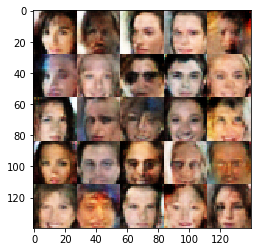

Steps 5810... Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.1372
Steps 5820... Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.4700
Steps 5830... Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.2242
Steps 5840... Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.3316
Steps 5850... Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.4455
Steps 5860... Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7391
Steps 5870... Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1325
Steps 5880... Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.8006
Steps 5890... Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.9782
Steps 5900... Epoch 1/1... Discriminator Loss: 1.8278... Generator Loss: 0.3251
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


Steps 5910... Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.8294
Steps 5920... Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 2.8971
Steps 5930... Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 2.1770
Steps 5940... Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0697
Steps 5950... Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8678
Steps 5960... Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 3.1286
Steps 5970... Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 2.3715
Steps 5980... Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.7462
Steps 5990... Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 2.4422
Steps 6000... Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.8911
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


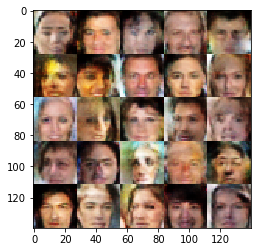

Steps 6010... Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.2693
Steps 6020... Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.2755
Steps 6030... Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.7220
Steps 6040... Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.3730
Steps 6050... Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 3.1144
Steps 6060... Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.7101
Steps 6070... Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8065
Steps 6080... Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.5691
Steps 6090... Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.8608
Steps 6100... Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.7524
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


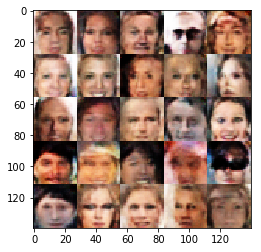

Steps 6110... Epoch 1/1... Discriminator Loss: 2.0211... Generator Loss: 0.2527
Steps 6120... Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.0359
Steps 6130... Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.2510
Steps 6140... Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.7917
Steps 6150... Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.2371
Steps 6160... Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 2.0199
Steps 6170... Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.7780
Steps 6180... Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.2268
Steps 6190... Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 3.3660
Steps 6200... Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.4382
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


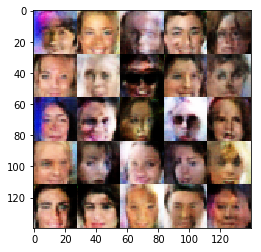

Steps 6210... Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.7156
Steps 6220... Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.1458
Steps 6230... Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.5704
Steps 6240... Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.4766
Steps 6250... Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 1.8432
Steps 6260... Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.5556
Steps 6270... Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.0521
Steps 6280... Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.0139
Steps 6290... Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.9544
Steps 6300... Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.4477
generator
x1: (?, 7, 7, 256)
x2: (?, 14, 14, 128)
x3: (?, 28, 28, 64)


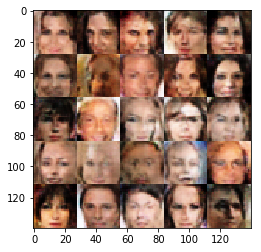

Steps 6310... Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 2.0369
Steps 6320... Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5568
Steps 6330... Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.2785


In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.